# Link neuropsych factors to patterns of connectivity

In this notebook, I will link the neuropsych factors (derived in previous notebook) can be linked to certain patterns of functional connectivity.  As in the end, we are mostly interested in the relation with psychosis, I will first look if there is predictive power for the diagnosis in the connectivity data.  The notebook is structured as follows:
1. Look at data
2. Predictive analysis of averaged (within networks) connectomes
3. Predictive analysis of connectomes (all parcel-to-parcel connections)
4. Cross-correlation between neuropsych measures and connectomes

In [1]:
from __future__ import division

#scikit-learn
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import image
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.cross_decomposition import *
from sklearn.model_selection import *
from sklearn.decomposition import *
from sklearn.cluster import *
from sklearn.svm import *

#rest
from utils.prog import log_progress as lp
from matplotlib.patches import Rectangle
import statsmodels.formula.api as smf
from numpy import transpose as T
from IPython.display import HTML
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.api as sm
from utils import neuropsych
import scipy.stats as stats
from scipy import interp
import matplotlib as mpl
import nibabel as nib
import seaborn as sns
import datetime as dt
import pandas as pd
import numpy as np
import palettable
import warnings
import scipy
import time
import json
import sys
import os

%matplotlib inline

cols = palettable.tableau.ColorBlind_10.hex_colors
cols += palettable.tableau.PurpleGray_6.hex_colors
cols += palettable.tableau.Tableau_10.hex_colors

CONDIR = os.environ.get("CONDIR")
CODEDIR = os.environ.get("CODEDIR")

## Data overview

#### Read in data
Read in subject-wise connectomes, results, factorsolution

In [2]:
gsr = '' if True else '_gsr'
connectomes = np.load(os.path.join(CONDIR,'derivatives/connectomes%s.npy'%gsr))
results = pd.read_csv(os.path.join(CONDIR,'derivatives/connectome_results.csv'),index_col=0)
factorsolution = pd.read_csv(os.path.join(os.environ.get("TABLEDIR"),"neuropsych_factor.csv"),index_col=0)

# check dimensions
assert(len(results)==connectomes.shape[2])

Extract labels of Gordon atlas

In [3]:
labelsfile = os.path.join(os.environ.get("CODEDIR"),"postbids/rest/Parcels.xlsx")
labeltable = pd.read_excel(labelsfile)
subprob = [[x+333,x+10+333] for x in range(10)]
subprob = [x for sublist in subprob for x in sublist]
cort = range(353,382)
order = np.argsort(labeltable.Community).tolist()+subprob+cort
labelnames = list(labeltable.Community[order][:333])+['subcort']*21+['cerebellum']*28
labels = np.unique(labelnames).tolist()
labelnames_unsorted = list(labeltable.Community)+['subcort']*21+['cerebellum']*28
ncon = len(labelnames)

#### Subset all connectomes/subjects that passed QC

Note: this is only for subjects that are in the factorsolution table, therefore only in the training dataset

In [4]:
# check which subjects pass QC
passubs = []
for idx,row in factorsolution.iterrows():
    ids = np.where(row.UID==results.subject)[0]
    qcs = np.where(np.logical_and(results.MRIQC_pass==1, results.MOTION_pass==1))[0]
    idqc = set(ids).intersection(qcs)
    if not len(idqc)==0:
        passubs.append(row.UID)

In [5]:
# combine QC'd results
ConClean = np.zeros([ncon,ncon,len(passubs)])
FacClean = pd.DataFrame({k:[] for k in factorsolution.columns})

for idx,sub in enumerate(passubs):
    ids = np.where(sub==results.subject)[0]
    qcs = np.where(np.logical_and(results.MRIQC_pass==1, results.MOTION_pass==1))[0]
    idqc = set(ids).intersection(qcs)
    con = np.mean(connectomes[:,:,np.array(list(idqc))],axis=2)
    con = con[:,order]
    con = con[order,:]
    ConClean[:,:,idx] = con
    FacRow = factorsolution.iloc[np.where(sub==factorsolution.UID)[0]]
    FacClean = FacClean.append(FacRow)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


#### Look at mean connectome

In [6]:
def gordon_figure(correlation,limits,labelnames,title,cmap="PuOr_r"):
    unique_labels = np.unique(labelnames)
    labels_num = [np.where(unique_labels==x)[0].tolist()[0] for val,x in enumerate(labelnames)]
    major_ticks = [np.min(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    minor_ticks = [np.mean(np.where(np.array(labels_num)==x))-1 for x in range(len(np.unique(labelnames)))]
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(correlation,cmap = cmap,vmin=limits[0],vmax=limits[1],aspect='auto',interpolation='nearest')
    ax.set_title(title)
    ax.set_xticks(major_ticks,minor=False)
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(unique_labels,minor=True,rotation=90)
    ax.set_xticklabels(unique_labels,minor=False,visible=False)
    ax.set_yticks(major_ticks,minor=False)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(unique_labels,minor=True)
    ax.set_yticklabels(unique_labels,minor=False,visible=False)
    plt.colorbar(ax1)
    plt.tight_layout()

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


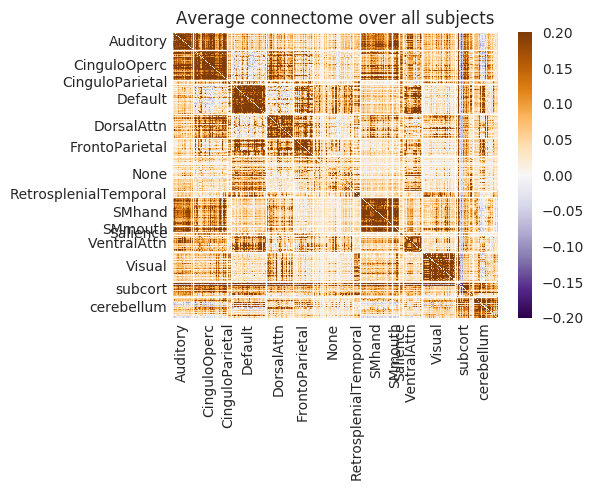

In [7]:
gordon_figure(np.mean(ConClean,axis=2),limits=[-0.2,0.2],labelnames=labelnames,
              title="Average connectome over all subjects")

#### Mean difference between patient groups

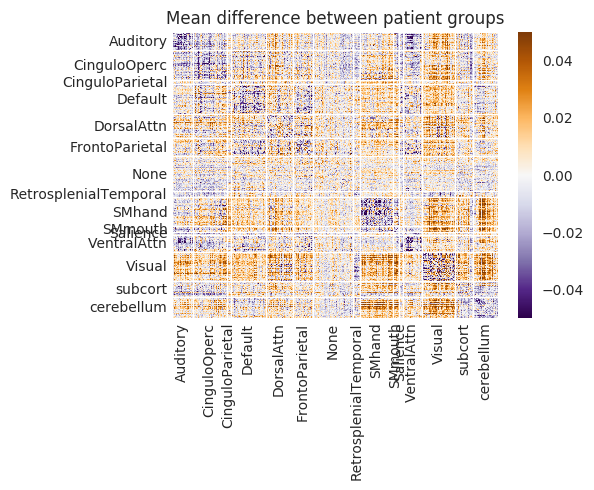

In [8]:
P = np.where(FacClean.patient=='patient')[0]
H = np.where(FacClean.patient=='HC')[0]
Pmn = ConClean[:,:,P]
Hmn = ConClean[:,:,H]
gordon_figure(np.mean(Pmn,axis=2)-np.mean(Hmn,axis=2),limits=[-0.05,0.05],labelnames=labelnames,
              title="Mean difference between patient groups")

## Predictive analysis of network-wise connectivity

#### Reduce connectomes to average within networks

In [9]:
con_av = np.zeros([len(labels),len(labels),ConClean.shape[2]])

for idx1,label1 in enumerate(labels):
    for idx2,label2 in enumerate(labels):
        x1 = np.where(np.array(labelnames) == label1)[0]
        x2 = np.where(np.array(labelnames) == label2)[0]
        subsel = ConClean[x1,:,:]
        subsel = subsel[:,x2,:]
        if label1==label2:
            upid = np.triu_indices(len(x1))
            av = np.mean(subsel[upid],axis=0)
        else:
            av = np.mean(subsel,axis=(0,1))
        con_av[idx1,idx2,:] = av

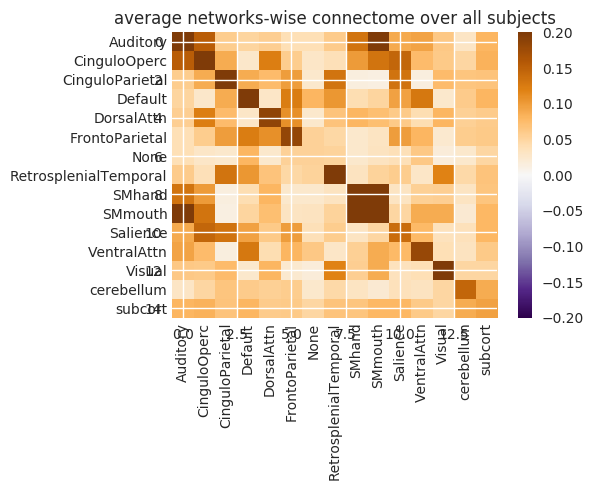

In [10]:
def cor_figure(cor,limits=[-0.2,0.2],title=''):
    labels_num = np.arange(15)
    minor_ticks = np.arange(15)
    fig = plt.figure(figsize=(6, 5), dpi= 100, facecolor='w', 
                     edgecolor='k')
    ax = fig.add_subplot(111)
    ax1 = ax.imshow(cor,cmap = "PuOr_r",vmin=limits[0],vmax=limits[1],aspect='auto',
                    interpolation='nearest')
    ax.set_title("average correlation (Z-scored) within parcels")
    ax.set_xticks(minor_ticks,minor=True)
    ax.set_xticklabels(labels,minor=True,rotation=90)
    ax.set_yticks(minor_ticks,minor=True)
    ax.set_yticklabels(labels,minor=True)
    plt.colorbar(ax1)
    plt.title(title)
    plt.tight_layout()

cor_figure(np.mean(con_av,axis=2),title='average networks-wise connectome over all subjects')

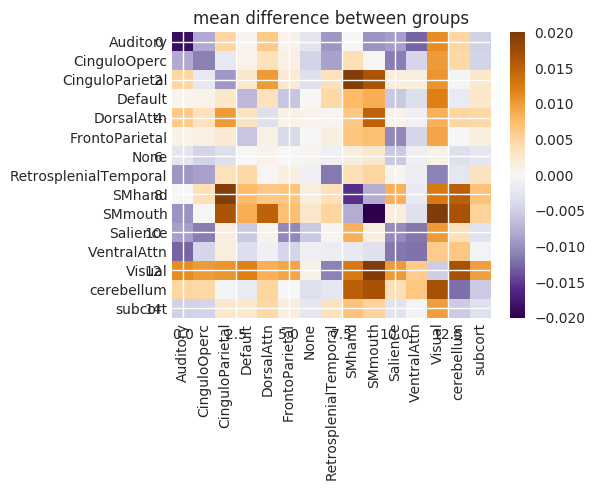

In [11]:
# look at mean difference to see if there's anything obvious to train
P = np.where(FacClean.patient=='patient')[0]
H = np.where(FacClean.patient=='HC')[0]
Pmn = con_av[:,:,P]
Hmn = con_av[:,:,H]
cor_figure(np.mean(Pmn,axis=2)-np.mean(Hmn,axis=2),limits=[-0.02,0.02],
           title = 'mean difference between groups')

#### Subset only upper diagonal and standardise rows

In [12]:
upid = np.triu_indices(15)
X_networks = np.transpose(con_av[upid])
Y_networks = np.array([1 if x=='patient' else 0 for x in FacClean.patient])

In [13]:
if True:
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_networks)
    X_networks = scaler.transform(X_networks)

#### Look at distribution of connectome for each subject

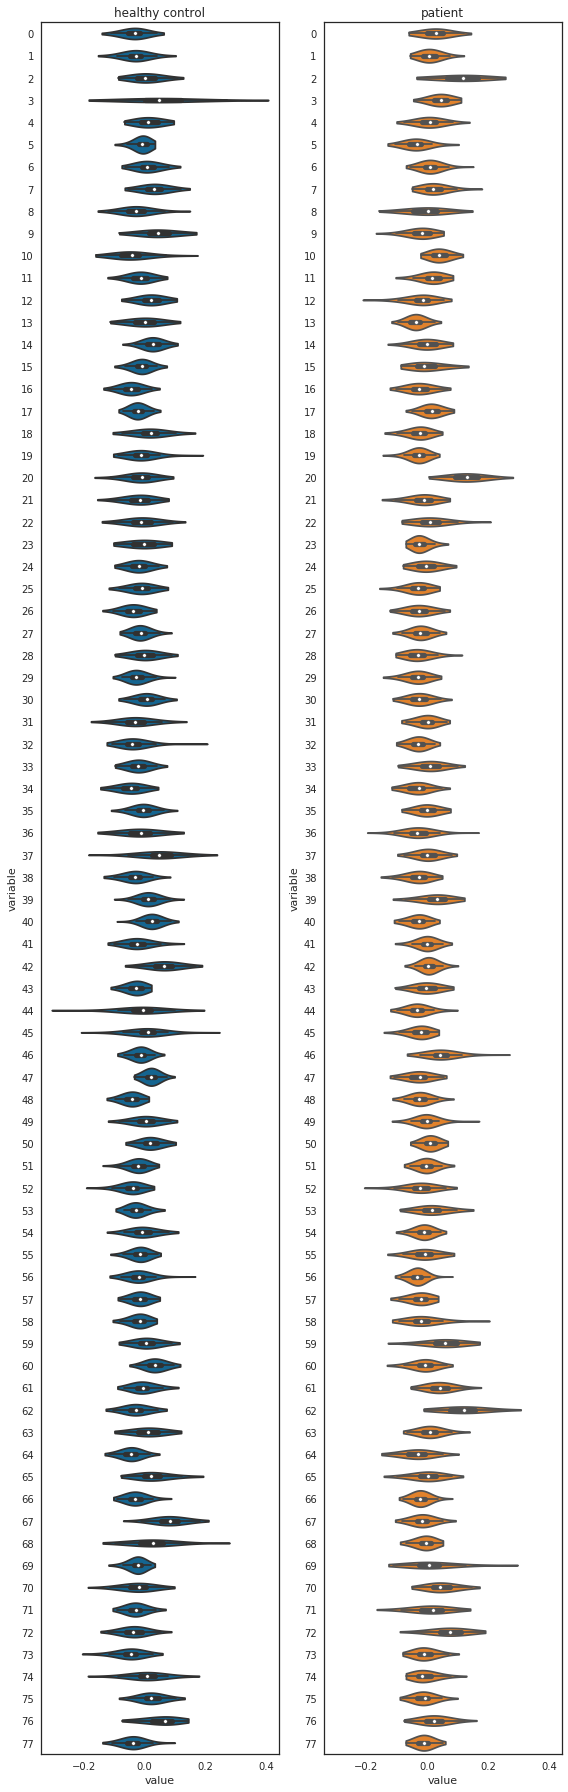

In [14]:
mpl.rcParams['grid.color'] = 'white'
sns.set_style('white')
f, axes = plt.subplots(1, 2, figsize=(8, 25), sharex=True)
for col in range(2):
    startr = [0,56][col]
    endr = [56,115][col]
    idx = np.where(Y_networks==col)[0]
    X_df = pd.DataFrame(np.transpose(X_networks[idx]))
    X_long = pd.melt(X_df,value_vars = range(78))
    sns.violinplot(x='value',y='variable',data=X_long,orient='h',bw=1,
                   title='distribution of continuous variables by patient',
                   ax=axes[col],cut=0,color=cols[col])
    axes[col].set_title('patient' if col==1 else 'healthy control')
    plt.tight_layout()

#### Predictive analysis: logistic regression

In [15]:
def compute_roc(X_init,Y_init,classifier,cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_init, Y_init):
        # fit
        ft = classifier.fit(X_init[train], Y_init[train])
        if hasattr(ft,'predict_proba'):
            probas_ = ft.predict_proba(X_init[test])
        else:
            probas_ = ft.decision_function(X_init[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_init[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1
    
    return mean_fpr,tprs,aucs

In [16]:
from sklearn.linear_model import LogisticRegression
K = 10
cv = StratifiedKFold(n_splits=K,shuffle=True,random_state = np.random.choice(2**32))
lr = LogisticRegression(dual=True,penalty="l2",solver='liblinear',C=0.2,class_weight='balanced')

mean_fpr,tprs,aucs = compute_roc(X_networks,Y_networks,lr,cv)

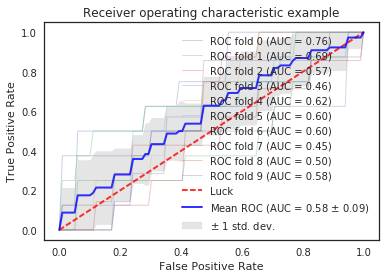

In [17]:
def roc_figure(mean_fpr,tprs,aucs):
    K = len(tprs)
    for k in range(K):
        plt.plot(mean_fpr,tprs[k],lw=1,alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (k, aucs[k]))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

roc_figure(mean_fpr,tprs,aucs)

Logistic regression seems to be working pretty good as seen on the ROC. 

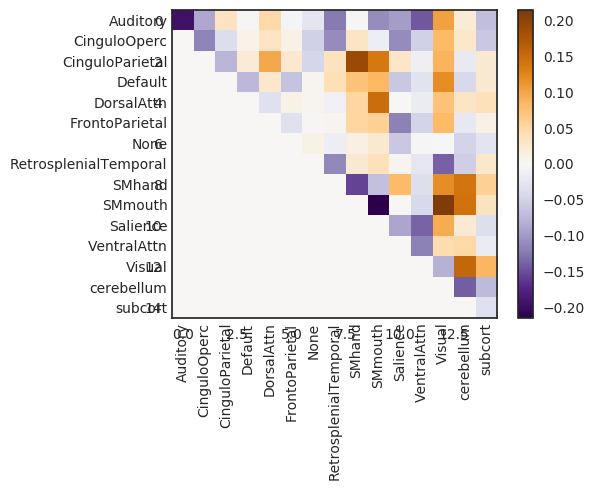

In [18]:
lr.fit(X_networks,Y_networks)
new = np.zeros([15,15])
new[upid]=lr.coef_[0,:]
lims = np.min([abs(min(new.flatten())),max(new.flatten())])
cor_figure(new,limits=[-lims,lims])

In [19]:
def plot_learning_curve(estimator,title,X,y,ylim,cv=None,n_jobs=3,
                        train_sizes = np.linspace(0.1,1.0,10)):
    plt.figure()
    plt.title(title)
    plt.ylim(ylim)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training sample size")
    plt.ylabel("classification accuracy")
    plt.legend()
    
    return train_scores_mean, test_scores_mean

(array([ 0.69642857,  0.72093023,  0.71923077,  0.68965517,  0.65940367,
         0.65384615,  0.64802632,  0.64942529,  0.65306122,  0.64220183]),
 array([ 0.57941028,  0.55924059,  0.57107695,  0.57080813,  0.57146337,
         0.55609879,  0.5484207 ,  0.59893313,  0.59606855,  0.60375504]))

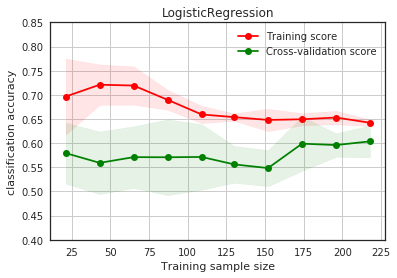

In [20]:
K = 8
cv = StratifiedKFold(n_splits=K)
sns.set_style("white")

plot_learning_curve(lr,"LogisticRegression",
                    X_networks,Y_networks,ylim=[0.4,0.85],cv=cv)

The fact that the lines for the training and cross-validation are not together, indicates that there is not enough data to fit the model optimally; and the model is atm overfitting.

#### Let's look at kernel methods: Support Vector Machines

In [21]:
def compute_roc(X_init,Y_init,classifier,cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_init, Y_init):
        # fit
        ft = classifier.fit(X_init[train], Y_init[train])
        if hasattr(ft,'predict_proba'):
            probas_ = ft.predict_proba(X_init[test])[:,1]
        else:
            probas_ = ft.decision_function(X_init[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_init[test], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        i += 1
    
    return mean_fpr,tprs,aucs

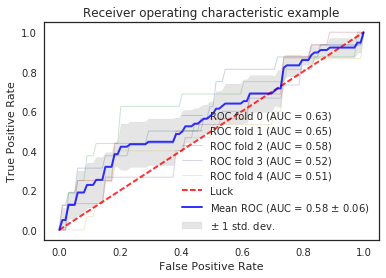

In [22]:
# compute AUC
K = 5
cv = StratifiedKFold(n_splits=K,shuffle=True,random_state = np.random.choice(2**32))
classifier = SVC(random_state=np.random.choice(2**32),kernel='linear',class_weight='balanced')

mean_fpr,tprs,aucs = compute_roc(X_networks,Y_networks,classifier,cv)

roc_figure(mean_fpr,tprs,aucs)

In [23]:
# classifier.fit(X_networks,Y_networks)
# new = np.zeros([15,15])
# new[upid]=np.mean(classifier.support_vectors_,axis=0)
# lims = np.min([abs(min(new.flatten())),max(new.flatten())])
# cor_figure(new,limits=[-lims,lims])

(array([ 0.75789474,  0.81025641,  0.72542373,  0.6835443 ,  0.6989899 ,
         0.70252101,  0.68920863,  0.67798742,  0.66927374,  0.66432161]),
 array([ 0.59547339,  0.59947339,  0.5707387 ,  0.57490196,  0.59082353,
         0.56234014,  0.56634014,  0.5905098 ,  0.59051301,  0.58242497]))

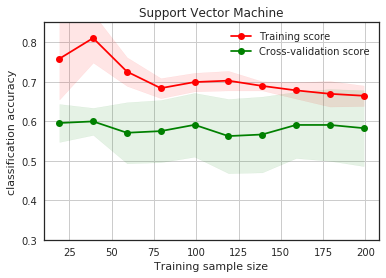

In [24]:
K = 8
sns.set_style("white")

plot_learning_curve(classifier,"Support Vector Machine",
                    X_networks,Y_networks,ylim=[0.3,0.85],cv=cv)

# Predictive analysis on all data

In [25]:
upid = np.triu_indices(ncon)
X_full = np.transpose(ConClean[upid])
if True:
    scaler = StandardScaler(with_std=False)
    scaler.fit(X_full)
    X_full = scaler.transform(X_full)
Y_full = np.array([1 if x=='patient' else 0 for x in FacClean.patient])

#### Logistic Regression

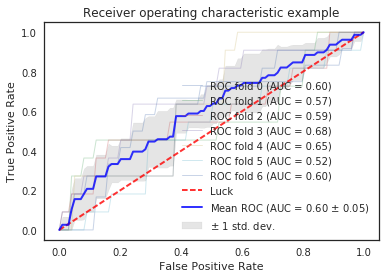

In [26]:
# compute AUC
K = 7
cv = StratifiedKFold(n_splits=K)
classifier = LogisticRegression(dual=True,penalty="l2",solver='liblinear',C=0.8)
#classifier = SVC(random_state=np.random.choice(2**32),probability=True,kernel='linear')

mean_fpr,tprs,aucs = compute_roc(X_full,Y_full,classifier,cv)
roc_figure(mean_fpr,tprs,aucs)

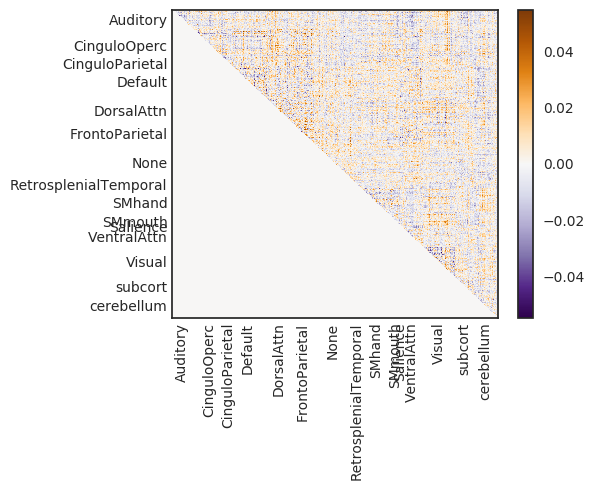

In [27]:
classifier.fit(X_full,Y_full)
new = np.zeros([ncon,ncon])
new[upid]=classifier.coef_[0,:]
lims = np.min([abs(min(new.flatten())),max(new.flatten())])
gordon_figure(new,limits=[-lims,lims],labelnames=labelnames,title="")

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 0.57096774,  0.55911458,  0.57173219,  0.56680108,  0.55572077,
         0.56754872,  0.54360719,  0.50846774,  0.47279066,  0.44023858]))

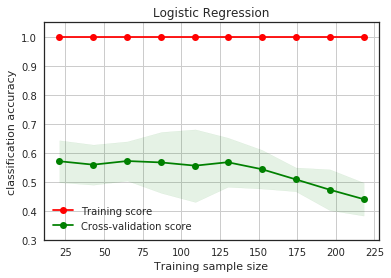

In [28]:
cv = StratifiedKFold(n_splits=8)
sns.set_style("white")

plot_learning_curve(classifier,"Logistic Regression",
                    X_full,Y_full,ylim=[0.3,1.05],cv=cv)

#### SVM

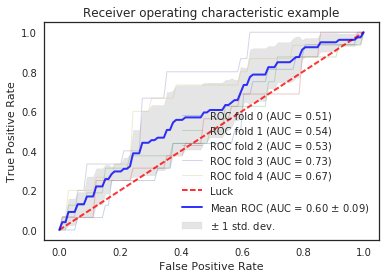

In [29]:
# compute AUC
K = 5
cv = StratifiedKFold(n_splits=K,shuffle=True,random_state = np.random.choice(2**32))
classifier = SVC(random_state=np.random.choice(2**32),probability=True,kernel='linear',
                 class_weight='balanced')

mean_fpr,tprs,aucs = compute_roc(X_full,Y_full,classifier,cv)

roc_figure(mean_fpr,tprs,aucs)

In [30]:
# classifier.fit(X_full,Y_full)
# print(classifier)
# new = np.zeros([ncon,ncon])
# new[upid]=classifier.coef_[0,:]
# lims = np.min([abs(min(new.flatten())),max(new.flatten())])
# gordon_figure(new,limits=[-lims,lims],labelnames=labelnames,title="")

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 array([ 0.6515373 ,  0.65063004,  0.67888105,  0.67106855,  0.68304772,
         0.68289651,  0.68289651,  0.68680276,  0.69084341,  0.6952621 ]))

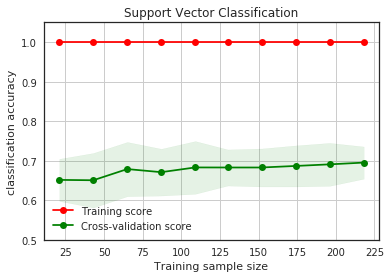

In [31]:
cv = StratifiedKFold(n_splits=8)
sns.set_style("white")

plot_learning_curve(classifier,"Support Vector Classification",
                    X_full,Y_full,ylim=[0.5,1.05],cv=cv)

That looks like a variance problem: overfitting on training dataset.

# More data driven clustering?

I'm currently trying to optimise the clustering of the connectomes to provide a more data driven clustering (rather than over the Gordon atlas networks).  To this end, I'm optimising the prediction accuracy as a function of clustering algorithm (factoranalysis, PCA, gaussian mixtures, k-mean,...) and the optimisation algorithm.
This is running in a separate notebook (and on the cluster).

# Neuropsych measures ~ Connectivity

Now that we know that a reasonable outcome can be found based on the averaged connectome, we will now link them to the neuropsych measures.

#### Split train-dev

In [32]:
facols = [x for x in FacClean.columns if x.startswith("factor")]
X = np.array(FacClean[facols])
print("shape of factor solution: %s"%str(X.shape))
Y = X_networks
print("shape of connectivity patterns: %s"%str(Y.shape))

shape of factor solution: (250, 10)
shape of connectivity patterns: (250, 120)


In [33]:
pool = range(X.shape[0])
tsi = list(np.random.choice(pool,int(0.2*X.shape[0]),replace=False))
tni = list(set(pool)-set(tsi))

In [34]:
X_train = X[tni,:]
X_test = X[tsi,:]
Y_train = Y[tni,:]
Y_test = Y[tsi,:]

### Apply CCA

In [35]:
assert(len(tsi)+len(tni)==int(X.shape[0]))
print("There are %i subjects in the training set"%(len(tni)))

There are 200 subjects in the training set


In [36]:
cca = PLSCanonical(n_components = 8)
cca.fit(X_train,Y_train)
X_transf,Y_transf = cca.transform(X_train,Y_train)

The figures below show the different components.

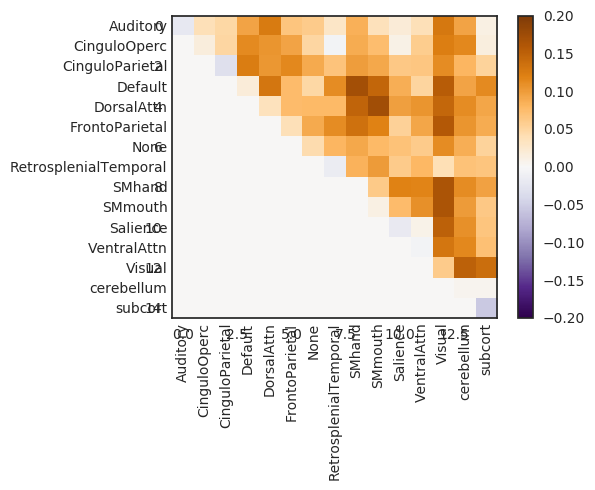

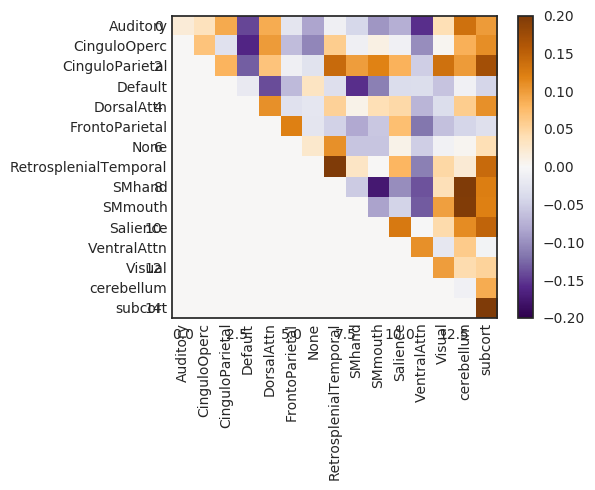

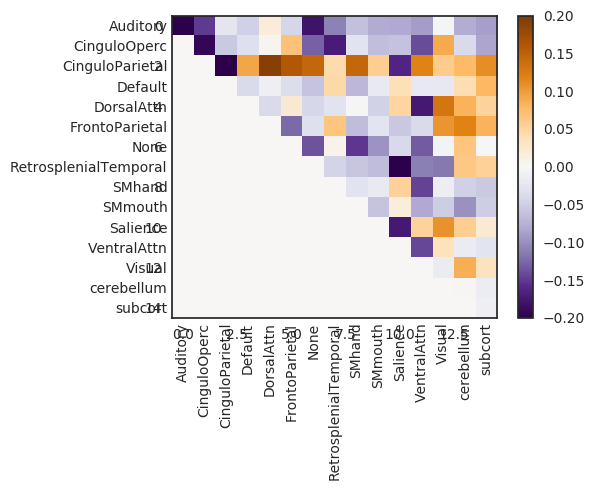

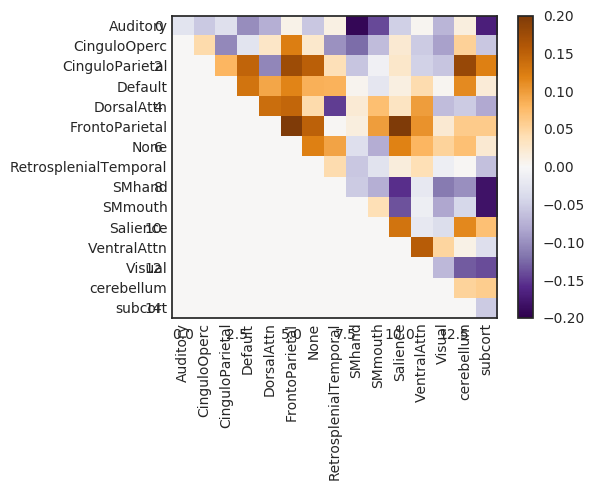

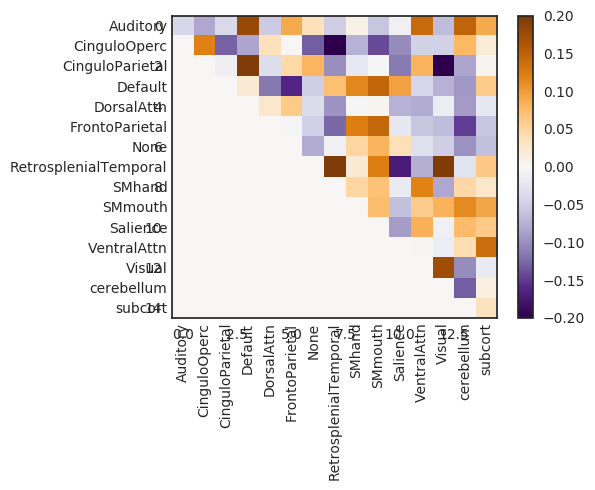

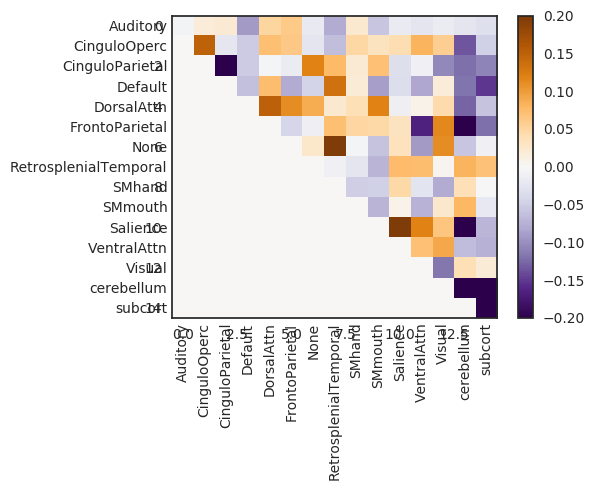

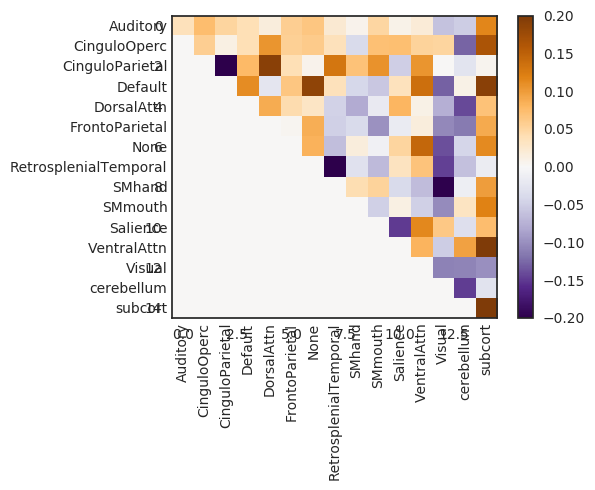

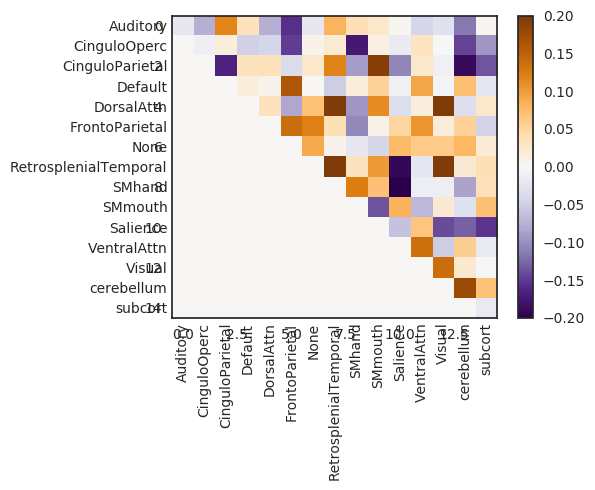

In [37]:
upid = np.triu_indices(15)
# canonische variabele 1
ncor = connectomes.shape[0]
canvar = np.zeros([15,15,8])
for cvar in range(8):
    canvar1 = cca.y_weights_[:,cvar]
    # terug naar correlatiematrix
    recon = np.zeros([15,15])
    recon[upid] = canvar1
    canvar[:,:,cvar] = recon
    cor_figure(recon)

The figure below shows how the canonical variables relate to the connectivity patterns.

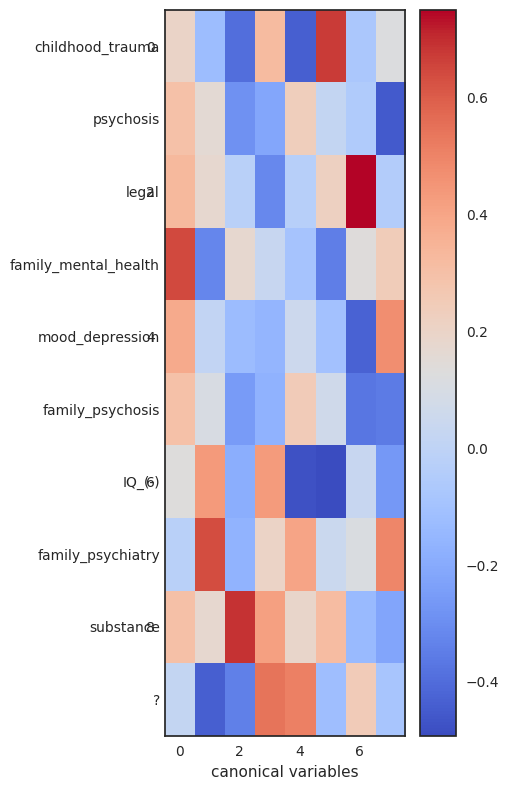

In [38]:
# this code makes nice figures of factors and their loadings

faclabels = ['childhood_trauma','psychosis','legal','family_mental_health','mood_depression','family_psychosis',
                'IQ_(-)','family_psychiatry','substance','?']

minor_ticks = np.arange(len(faclabels))

fig = plt.figure(figsize=(5, 8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax1 = ax.imshow(cca.x_weights_,
                aspect='auto',interpolation='nearest',cmap='coolwarm')
ax.set_yticks(np.arange(len(faclabels)),minor=True)
ax.set_yticklabels(faclabels,minor=True)
ax.set_xlabel("canonical variables")
plt.colorbar(ax1)
plt.tight_layout()


The table below shows the cross-validation p-value, and show that this canonical correlation analsyis did not really work :-) .

In [39]:
X_transf,Y_transf = cca.transform(X_test,Y_test)
X_transf.shape
results = pd.DataFrame({"CV correlation":[],"CV p-value":[]})
for x in range(8):
    ccacor = stats.pearsonr(X_transf[:,x],Y_transf[:,x])
    row = {"CV correlation":ccacor[0],'CV p-value':ccacor[1]}
    results = results.append(row,ignore_index=True)

results

,CV correlation,CV p-value
0,0.060388,0.676982
1,0.053717,0.711011
2,0.060863,0.674582
3,0.175579,0.222606
4,-0.079741,0.581997
5,0.163598,0.256281
6,-0.076149,0.599167
7,-0.304959,0.031285
